In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Gives us Graphics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

url = 'https://raw.githubusercontent.com/beespinosa1/Inter/main/Escenario2.csv'

In [2]:
df = pd.read_csv(url)
df= pd.read_csv(url,low_memory=False)
dataframe= pd.read_csv(url,low_memory=False)

In [3]:
# Normalise the data
def dfNormalize(df):
    for feature_name in df.columns:
        df.loc[:,feature_name]= pd.to_numeric(df.loc[:,feature_name], errors='coerce').fillna(0)
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()   
        if (max_value - min_value) > 0:
            df.loc[:,feature_name] = (df.loc[:,feature_name] - min_value) / (max_value - min_value)
        else:
            df.loc[:,feature_name] = (df.loc[:,feature_name]- min_value)    
    return df

In [4]:
dataframe = dataframe.reindex(np.random.permutation(dataframe.index)).copy()
print(dataframe.describe())
print(list(dataframe))

        Source Port   Destination Port   Protocol   Flow Duration  \
count   3000.000000        3000.000000     3000.0    3.000000e+03   
mean   48455.594667        3252.134667        6.0    4.295469e+05   
std     8966.042102        9405.481170        0.0    1.147671e+06   
min       80.000000          21.000000        6.0    1.700000e+01   
25%    41833.000000          80.000000        6.0    7.964075e+04   
50%    49577.000000         443.000000        6.0    2.068215e+05   
75%    55923.000000         443.000000        6.0    2.168172e+05   
max    61156.000000       65514.000000        6.0    9.904104e+06   

        Flow Bytes/s   Flow Packets/s   Flow IAT Mean   Flow IAT Std  \
count         3000.0      3000.000000    3.000000e+03   3.000000e+03   
mean             0.0       462.782031    3.140976e+05   1.198478e+05   
std              0.0      5298.098971    7.503888e+05   6.030572e+05   
min              0.0         0.201936    1.150000e+01   0.000000e+00   
25%              0

In [5]:
keys = dataframe.keys()

data_to_process = dataframe[keys[4:len(keys)-1]].copy()

x_normalised=dfNormalize(data_to_process)

In [6]:
# get the train and test data
y = dataframe['label']
change_labels = lambda x: 1 if x == 'nonTOR' else 0
y_normalised = dataframe['label'].apply(change_labels)

x_train,x_test,y_train,y_test = train_test_split(x_normalised,
                                                 y_normalised,
                                                 test_size=0.3, # %test
                                                 random_state=0)

x_train.shape, x_test.shape

((2100, 24), (900, 24))

In [7]:
# Define the SAE model
input_dim = x_train.shape[1]
hidden_dim1 = 64
hidden_dim2 = 32

input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder1 = tf.keras.layers.Dense(hidden_dim1, activation="relu")(input_layer)
encoder2 = tf.keras.layers.Dense(hidden_dim2, activation="relu")(encoder1)
decoder1 = tf.keras.layers.Dense(hidden_dim1, activation="relu")(encoder2)
output_layer = tf.keras.layers.Dense(input_dim, activation="sigmoid")(decoder1)

sae = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [8]:
# Compile and train the SAE model
sae.compile(optimizer='adam', loss='mean_squared_error')
sae.fit(x_train, x_train, epochs=50, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/50
66/66 [==============================] - 1s 3ms/step - loss: 0.1581 - val_loss: 0.0122
Epoch 2/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 3/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 4/50
66/66 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 5/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 6/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 8/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 10/50
66/66 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 11/50
66/66 [

In [9]:
# Use the encoder layers to get the reduced features
encoder = tf.keras.Model(inputs=input_layer, outputs=encoder2)
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

29/29 [==============================] - 0s 536us/step


In [10]:
# Train a logistic regression classifier using the reduced features
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=10000)
clf.fit(x_train_encoded, y_train)
y_pred = clf.predict(x_test_encoded)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score

clf = MultinomialNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

# Print predicted labels
print(y_pred)
#Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_test, y_pred, average='macro')
print('METRICS FOR THE MODEL')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('F1-score:', f1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

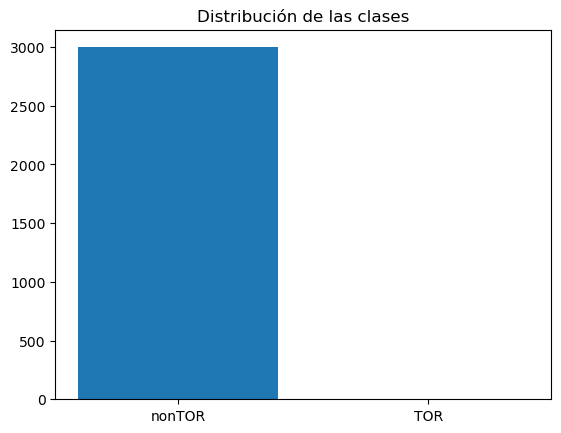

In [14]:
counts = y.value_counts()
plt.bar(counts.index, counts.values)
plt.title("Distribución de las clases")
plt.show()